In [1]:
import numpy as np
import pandas as pd
from cellpose import models, io, plot
import matplotlib.pyplot as plt
from skimage import measure
from skimage.filters import threshold_otsu
from skimage import morphology
from skimage import filters
from scipy.stats import mannwhitneyu




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	darwin 
python version: 	3.9.22 
torch version:  	2.7.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:


# # File paths
# mhtt_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=0.tif'
# cct1_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=1.tif'

# # Load the TIFF files
# mhtt_data = tifffile.imread(mhtt_path)  # Shape: (Z, Y, X)
# cct1_data = tifffile.imread(cct1_path)  # Shape: (Z, Y, X)

# # Verify the shapes
# print(f"mHTT data shape: {mhtt_data.shape}")
# print(f"CCT1 data shape: {cct1_data.shape}")

# # Create output directories for Z-slices
# mhtt_output_dir = "mhtt_z_slices"
# cct1_output_dir = "cct1_z_slices"
# os.makedirs(mhtt_output_dir, exist_ok=True)
# os.makedirs(cct1_output_dir, exist_ok=True)

# # Save each Z-slice as a separate TIFF file
# for z in range(mhtt_data.shape[0]):
#     mhtt_slice_path = os.path.join(mhtt_output_dir, f"mhtt_slice_{z}.tiff")
#     cct1_slice_path = os.path.join(cct1_output_dir, f"cct1_slice_{z}.tiff")
    
#     # Save mHTT Z-slice
#     tifffile.imwrite(mhtt_slice_path, mhtt_data[z])
    
#     # Save CCT1 Z-slice
#     tifffile.imwrite(cct1_slice_path, cct1_data[z])

# print(f"Saved {mhtt_data.shape[0]} Z-slices for mHTT to '{mhtt_output_dir}'")
# print(f"Saved {cct1_data.shape[0]} Z-slices for CCT1 to '{cct1_output_dir}'")

# # Display all Z-slices in a grid
# num_slices = mhtt_data.shape[0]
# grid_size = int(np.ceil(np.sqrt(num_slices)))

# # Create a figure to display all mHTT Z-slices
# fig1, axes1 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
# fig1.suptitle('mHTT Z-Slices', fontsize=16)

# # Create a figure to display all CCT1 Z-slices
# fig2, axes2 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
# fig2.suptitle('CCT1 Z-Slices', fontsize=16)

# # Normalize the intensity for better visualization
# def normalize(img):
#     return (img - img.min()) / (img.max() - img.min())

# # Plot each Z-slice
# for z in range(num_slices):
#     row, col = z // grid_size, z % grid_size
    
#     # mHTT slice
#     ax1 = axes1[row, col]
#     ax1.imshow(normalize(mhtt_data[z]), cmap='gray')
#     ax1.set_title(f"Slice {z}")
#     ax1.axis('off')
    
#     # CCT1 slice
#     ax2 = axes2[row, col]
#     ax2.imshow(normalize(cct1_data[z]), cmap='gray')
#     ax2.set_title(f"Slice {z}")
#     ax2.axis('off')

# # Turn off remaining empty subplots
# for z in range(num_slices, grid_size**2):
#     row, col = z // grid_size, z % grid_size
#     axes1[row, col].axis('off')
#     axes2[row, col].axis('off')

# plt.tight_layout()
# plt.show()

# # Create maximum intensity projections (MIP)
# mhtt_mip = np.max(mhtt_data, axis=0)
# cct1_mip = np.max(cct1_data, axis=0)

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(normalize(mhtt_mip), cmap='gray')

# plt.title("mHTT Maximum Intensity Projection")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(normalize(cct1_mip), cmap='gray')
# plt.title("CCT1 Maximum Intensity Projection")
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# Cellpose implementation

In [3]:
tif_file= f"/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3_MAX_Composite.tif"
img = io.imread(tif_file) # (9, 4, 1024, 1024)
print(f'img : {img.shape}')

img : (4, 2048, 2048)


In [4]:
model = models.CellposeModel()
# NUCLEI
nuclei = img[2, :, :]
print(f'Nuclei : {nuclei.shape}')

# CCT1
CCT1 = img[0, :, :]
print(f'CCT1 : {CCT1.shape}')

# mHTT
mHTT = img[1, :, :] 
print(f'mHTT : {mHTT.shape}')

Nuclei : (2048, 2048)
CCT1 : (2048, 2048)
mHTT : (2048, 2048)


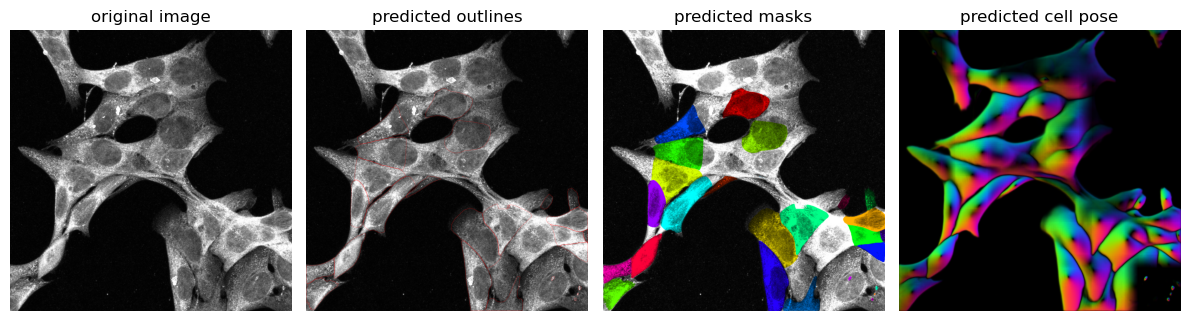

In [5]:
mHTT_masks, mHTT_flows, mHTT_styles = model.eval(
                                                        mHTT,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=50,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, mHTT, mHTT_masks, mHTT_flows[0])
plt.tight_layout()
plt.show()

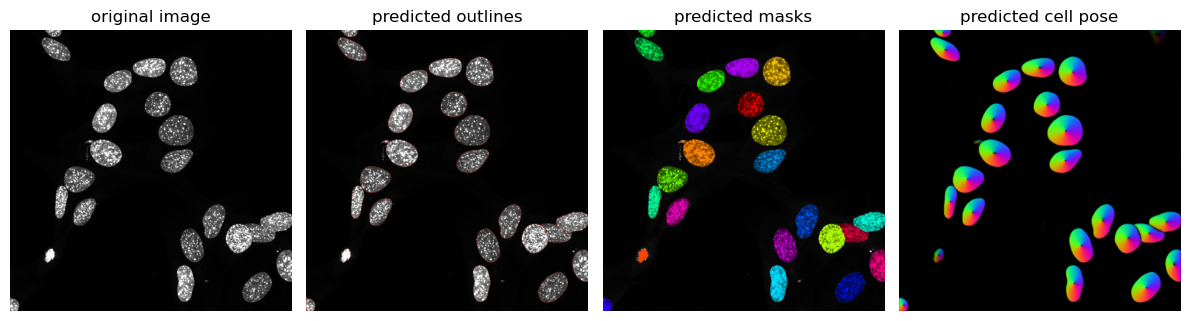

In [6]:


masks_nuclei, flows_nuclei, styles_nuclei = model.eval(
                                                        nuclei,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=50,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, nuclei, masks_nuclei, flows_nuclei[0])
plt.tight_layout()
plt.show()

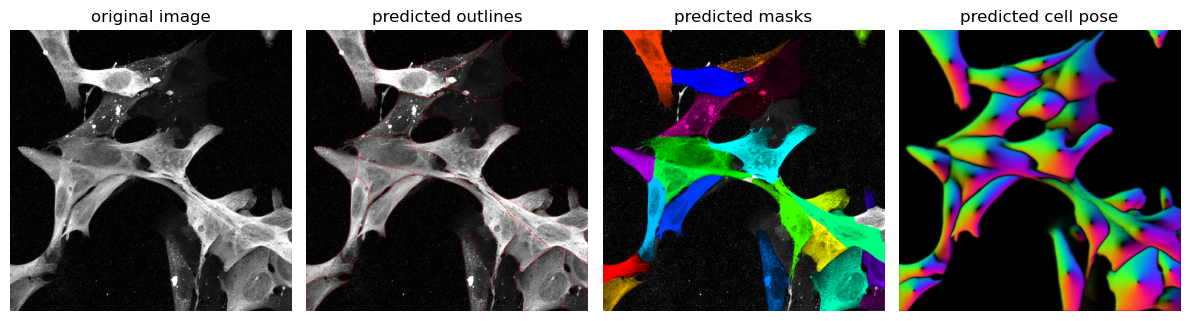

In [7]:
masks_CCT1, flows_CCT1, styles_CCT1 = model.eval(
                                                        CCT1,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=100,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, CCT1, masks_CCT1, flows_CCT1[0])
plt.tight_layout()
plt.show()

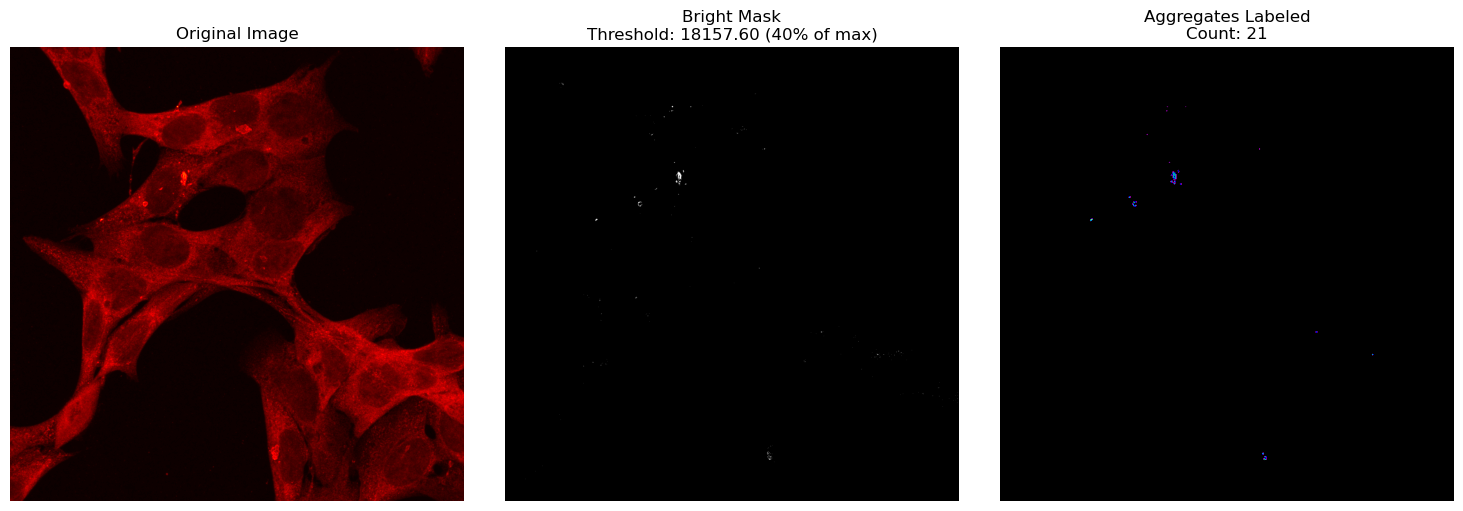

Total aggregations: 21


In [8]:


# Use Otsu's method for automatic thresholding
# This finds optimal threshold by maximizing variance between foreground and background
thresh_otsu = threshold_otsu(mHTT)

# Create binary mask by applying Otsu threshold
bright_spots = mHTT > thresh_otsu
# Use a relative threshold (40% of max intensity) instead of Otsu
# This gives better control over aggregate detection sensitivity
threshold = 0.4 * np.max(mHTT)

# Create binary mask by applying threshold
bright_spots = mHTT > threshold

# Remove small objects (noise) from the binary mask
# min_size=10 removes connected regions smaller than 10 pixels
clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)

# Label connected components (each distinct region gets unique integer ID)
labeled_mask = measure.label(clean_mask)
num_aggregations = labeled_mask.max()  # Count the number of unique regions

# Visualization section - create figure with 3 panels
plt.figure(figsize=(15, 5))

# Panel 1: Display original image using 'hot' colormap to highlight bright aggregates
plt.subplot(1, 3, 1)
plt.imshow(mHTT, cmap='hot')
plt.axis('off')
plt.title('Original Image')

# Panel 2: Show binary mask (threshold result)
plt.subplot(1, 3, 2)
plt.imshow(bright_spots, cmap='gray')
plt.axis('off')
plt.title(f'Bright Mask\nThreshold: {threshold:.2f} (40% of max)')

# Panel 3: Show labeled regions with different colors
# nipy_spectral colormap gives distinct colors to different labeled regions
plt.subplot(1, 3, 3)
plt.imshow(labeled_mask, cmap='nipy_spectral')
plt.axis('off')
plt.title(f'Aggregates Labeled\nCount: {num_aggregations}')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total aggregations: {num_aggregations}")


CCT1 background mean: 7299.31, std: 9707.77
CCT1 thresholds - Otsu: 11891.0, BG+2σ: 26714.8, BG+3σ: 36422.6


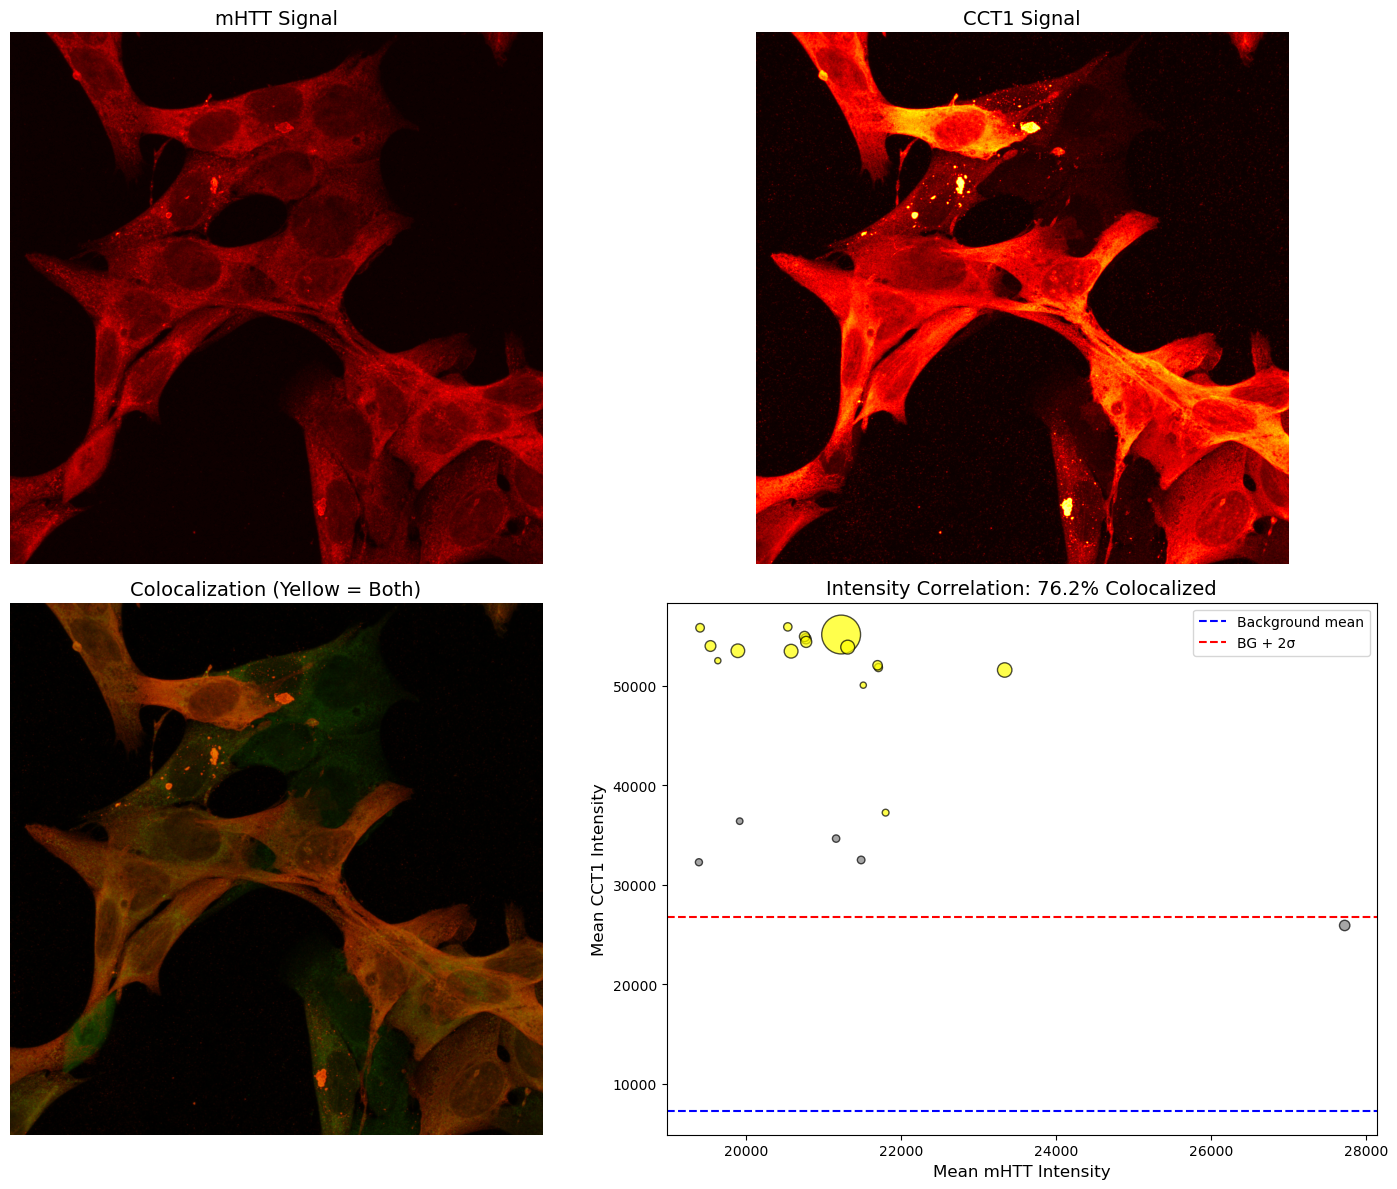

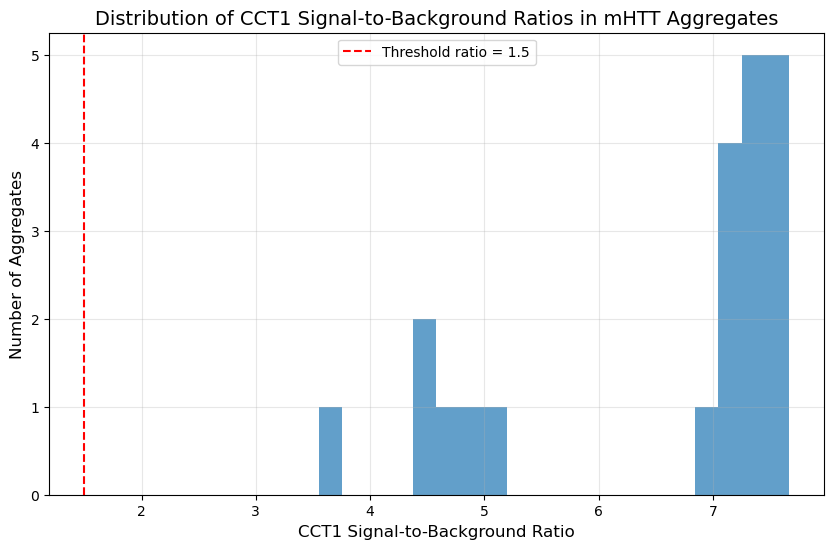

Total mHTT aggregates: 21
Aggregates with CCT1 colocalization (strict criteria): 16 (76.2%)

Top 5 aggregates by CCT1 signal-to-background ratio:
    aggregate_id   area     mean_mHTT     mean_CCT1  signal_to_bg_ratio  \
18            19   18.0  20536.277778  55934.444444            7.662981   
19            20   19.0  19403.526316  55843.947368            7.650583   
7              8  391.0  21224.892583  55165.948849            7.557697   
10            11   27.0  20752.259259  54968.296296            7.530619   
9             10   27.0  20770.407407  54738.851852            7.499185   

     z_score  
18  5.009919  
19  5.000597  
7   4.930756  
10  4.910396  
9   4.886761  


In [9]:
# 1. Get mHTT aggregates from labeled_mask
mhtt_props = measure.regionprops(labeled_mask, intensity_image=mHTT)

# 2. Calculate background CCT1 signal by sampling regions outside aggregates
# Create a mask of non-aggregate regions
background_mask = labeled_mask == 0
# Sample CCT1 values from background regions
background_cct1 = CCT1[background_mask]
background_mean = np.mean(background_cct1)
background_std = np.std(background_cct1)

print(f"CCT1 background mean: {background_mean:.2f}, std: {background_std:.2f}")

# Define multiple threshold methods for comparison
cct1_thresh_otsu = threshold_otsu(CCT1)
cct1_thresh_bg_plus_2std = background_mean + (2 * background_std)  # 2 standard deviations above background
cct1_thresh_bg_plus_3std = background_mean + (3 * background_std)  # 3 standard deviations above background

print(f"CCT1 thresholds - Otsu: {cct1_thresh_otsu:.1f}, BG+2σ: {cct1_thresh_bg_plus_2std:.1f}, BG+3σ: {cct1_thresh_bg_plus_3std:.1f}")

# 3. Analyze each mHTT aggregate for CCT1 colocalization with multiple criteria
colocalization_data = []

for i, region in enumerate(mhtt_props):
    # Get the coordinates of this aggregate
    coords = region.coords  # Array of (row, col) coordinates
    
    # Extract CCT1 intensities at these same coordinates
    cct1_values = np.array([CCT1[y, x] for y, x in coords])
    
    # Calculate statistics
    mean_cct1 = np.mean(cct1_values)
    max_cct1 = np.max(cct1_values)
    
    # Calculate signal-to-background ratio
    signal_to_bg_ratio = mean_cct1 / background_mean if background_mean > 0 else 0
    
    # Z-score relative to background
    z_score = (mean_cct1 - background_mean) / background_std if background_std > 0 else 0
    
    # Determine colocalization by different criteria
    percent_above_otsu = np.mean(cct1_values > cct1_thresh_otsu) * 100
    percent_above_2std = np.mean(cct1_values > cct1_thresh_bg_plus_2std) * 100
    percent_above_3std = np.mean(cct1_values > cct1_thresh_bg_plus_3std) * 100
    
    # Stringent colocalization criteria (multiple must be met)
    has_cct1_strict = (signal_to_bg_ratio > 1.5) and (z_score > 3) and (percent_above_2std > 50)
    
    # Store data for this aggregate
    colocalization_data.append({
        'aggregate_id': i+1,
        'area': region.area,
        'mean_mHTT': region.mean_intensity,
        'mean_CCT1': mean_cct1,
        'max_CCT1': max_cct1,
        'signal_to_bg_ratio': signal_to_bg_ratio,
        'z_score': z_score,
        'percent_above_otsu': percent_above_otsu,
        'percent_above_2std': percent_above_2std,
        'percent_above_3std': percent_above_3std,
        'has_CCT1_colocalization': has_cct1_strict
    })

# 4. Convert to DataFrame for analysis
df_colocalization = pd.DataFrame(colocalization_data)

# 5. Calculate summary statistics
total_aggregates = len(df_colocalization)
colocalized_aggregates = df_colocalization['has_CCT1_colocalization'].sum()
percent_colocalized = (colocalized_aggregates / total_aggregates) * 100 if total_aggregates > 0 else 0

# 6. Visualize the results
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Original images
axs[0, 0].imshow(mHTT, cmap='hot')
axs[0, 0].set_title('mHTT Signal', fontsize=14)
axs[0, 0].axis('off')

axs[0, 1].imshow(CCT1, cmap='hot')
axs[0, 1].set_title('CCT1 Signal', fontsize=14)
axs[0, 1].axis('off')

# Create RGB overlay showing colocalization
overlay = np.zeros((mHTT.shape[0], mHTT.shape[1], 3), dtype=float)
# Normalize channels for visualization
mhtt_norm = (mHTT - np.min(mHTT)) / (np.max(mHTT) - np.min(mHTT))
cct1_norm = (CCT1 - np.min(CCT1)) / (np.max(CCT1) - np.min(CCT1))
# Green for mHTT, Red for CCT1
overlay[:,:,1] = mhtt_norm  # Green
overlay[:,:,0] = cct1_norm  # Red
# Yellow indicates colocalization

axs[1, 0].imshow(overlay)
axs[1, 0].set_title('Colocalization (Yellow = Both)', fontsize=14)
axs[1, 0].axis('off')

# Create a scatter plot of CCT1 vs mHTT intensities
axs[1, 1].scatter(
    df_colocalization['mean_mHTT'], 
    df_colocalization['mean_CCT1'],
    c=df_colocalization['has_CCT1_colocalization'].map({True: 'yellow', False: 'gray'}),
    s=df_colocalization['area']*2,
    alpha=0.7,
    edgecolors='black'
)
axs[1, 1].axhline(background_mean, color='blue', linestyle='--', label='Background mean')
axs[1, 1].axhline(cct1_thresh_bg_plus_2std, color='red', linestyle='--', label='BG + 2σ')
axs[1, 1].set_xlabel('Mean mHTT Intensity', fontsize=12)
axs[1, 1].set_ylabel('Mean CCT1 Intensity', fontsize=12)
axs[1, 1].set_title(f'Intensity Correlation: {percent_colocalized:.1f}% Colocalized', fontsize=14)
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Show distribution of signal-to-background ratios
plt.figure(figsize=(10, 6))
plt.hist(df_colocalization['signal_to_bg_ratio'], bins=20, alpha=0.7)
plt.axvline(1.5, color='red', linestyle='--', label='Threshold ratio = 1.5')
plt.xlabel('CCT1 Signal-to-Background Ratio', fontsize=12)
plt.ylabel('Number of Aggregates', fontsize=12)
plt.title('Distribution of CCT1 Signal-to-Background Ratios in mHTT Aggregates', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print detailed statistics
print(f"Total mHTT aggregates: {total_aggregates}")
print(f"Aggregates with CCT1 colocalization (strict criteria): {colocalized_aggregates} ({percent_colocalized:.1f}%)")
print("\nTop 5 aggregates by CCT1 signal-to-background ratio:")
print(df_colocalization.sort_values('signal_to_bg_ratio', ascending=False).head(5)[
    ['aggregate_id', 'area', 'mean_mHTT', 'mean_CCT1', 'signal_to_bg_ratio', 'z_score']])

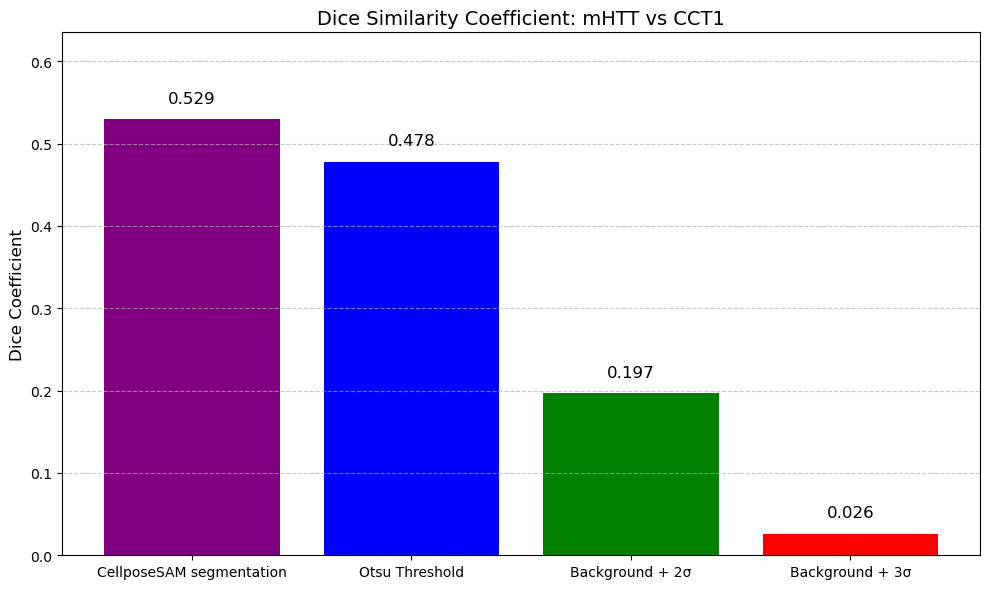

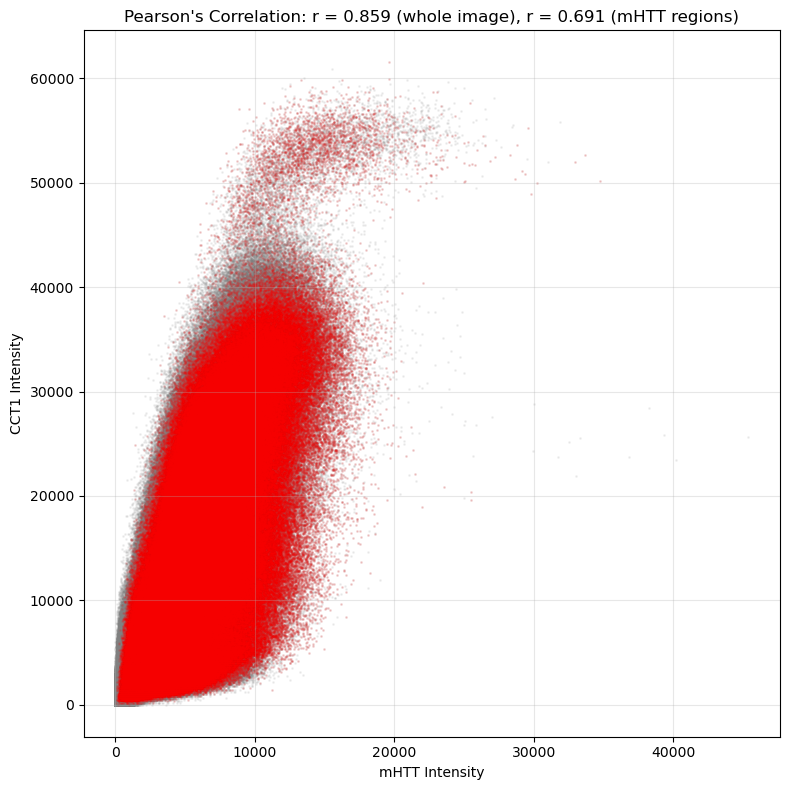

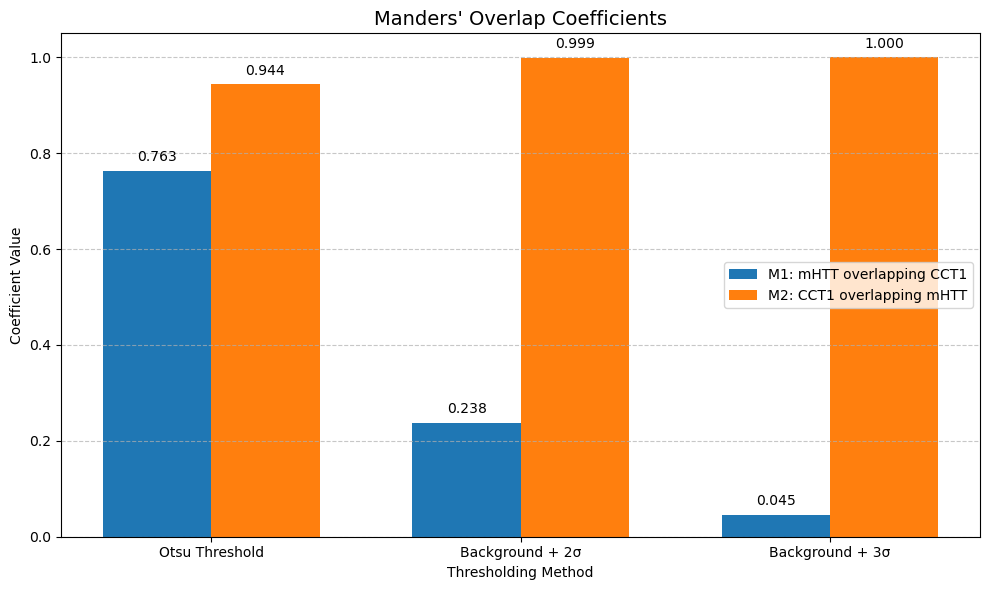

Dice Similarity Coefficient Results:
CellposeSAM segmentation: 0.5293
Otsu Threshold: 0.4778
Background + 2σ: 0.1965
Background + 3σ: 0.0261

Optimal CCT1 threshold: 7299.31
Maximum DSC achieved: 0.5217

Nuclear association:
mHTT-Nuclei overlap: 0.4559
CCT1-Nuclei overlap: 0.4499

Pearson's Correlation Coefficient:
Whole image: 0.8592
Within mHTT regions: 0.6905

Manders' Overlap Coefficients:
Otsu Threshold: M1 = 0.7632 (mHTT), M2 = 0.9436 (CCT1)
Background + 2σ: M1 = 0.2378 (mHTT), M2 = 0.9987 (CCT1)
Background + 3σ: M1 = 0.0453 (mHTT), M2 = 1.0000 (CCT1)


In [10]:
def dice_coefficient(mask1, mask2):
    """
    Calculate Dice Similarity Coefficient between two binary masks
    DSC = 2*|intersection| / (|mask1| + |mask2|)
    """
    intersection = np.logical_and(mask1, mask2)
    if mask1.sum() + mask2.sum() == 0:
        return 0  # Avoid division by zero
    dice = (2.0 * intersection.sum()) / (mask1.sum() + mask2.sum())
    return dice

def pearson_correlation(img1, img2, mask=None):
    """
    Calculate Pearson's correlation coefficient between two images
    Optional mask can restrict the calculation to specific regions
    """
    if mask is not None:
        img1_masked = img1[mask]
        img2_masked = img2[mask]
        if len(img1_masked) == 0:  # Empty mask
            return 0
        return np.corrcoef(img1_masked, img2_masked)[0, 1]
    else:
        return np.corrcoef(img1.flatten(), img2.flatten())[0, 1]

def manders_coefficients(img1, img2, threshold1=None, threshold2=None):
    """
    Calculate Manders' Overlap Coefficients (M1, M2)
    M1: fraction of img1 overlapping with img2
    M2: fraction of img2 overlapping with img1
    
    If thresholds are not provided, Otsu's method will be used
    """
    # Apply thresholds if not provided
    if threshold1 is None:
        threshold1 = filters.threshold_otsu(img1)
    if threshold2 is None:
        threshold2 = filters.threshold_otsu(img2)
    
    # Create binary masks
    mask1 = img1 > threshold1
    mask2 = img2 > threshold2
    
    # Calculate intersection
    intersection = np.logical_and(mask1, mask2)
    
    # M1: sum of intensities in img1 where img2 is above threshold, divided by total intensity in img1
    img1_total = np.sum(img1[mask1])
    img1_coloc = np.sum(img1[intersection])
    
    # M2: sum of intensities in img2 where img1 is above threshold, divided by total intensity in img2
    img2_total = np.sum(img2[mask2])
    img2_coloc = np.sum(img2[intersection])
    
    # Calculate coefficients
    M1 = img1_coloc / img1_total if img1_total > 0 else 0
    M2 = img2_coloc / img2_total if img2_total > 0 else 0
    
    return M1, M2

# Use cellpose masks for better segmentation
mhtt_binary = mHTT_masks > 0
cct1_binary = masks_CCT1 > 0
nuclei_binary = masks_nuclei > 0

# Create CCT1 binary masks using different thresholding methods
cct1_otsu_binary = CCT1 > cct1_thresh_otsu
cct1_bg2std_binary = CCT1 > cct1_thresh_bg_plus_2std
cct1_bg3std_binary = CCT1 > cct1_thresh_bg_plus_3std

# Calculate Dice coefficients for each method
dice_scores = {
    'CellposeSAM segmentation': dice_coefficient(mhtt_binary, cct1_binary),
    'Otsu Threshold': dice_coefficient(mhtt_binary, cct1_otsu_binary),
    'Background + 2σ': dice_coefficient(mhtt_binary, cct1_bg2std_binary),
    'Background + 3σ': dice_coefficient(mhtt_binary, cct1_bg3std_binary)
}

# Calculate Pearson's correlation coefficient (whole image and within mHTT regions)
pearson_whole = pearson_correlation(mHTT, CCT1)
pearson_mhtt_regions = pearson_correlation(mHTT, CCT1, mask=mhtt_binary)

# Calculate Manders' coefficients
# M1: fraction of mHTT overlapping with CCT1 
# M2: fraction of CCT1 overlapping with mHTT
M1_otsu, M2_otsu = manders_coefficients(mHTT, CCT1)
M1_bg2std, M2_bg2std = manders_coefficients(mHTT, CCT1, 
                                           threshold2=cct1_thresh_bg_plus_2std)
M1_bg3std, M2_bg3std = manders_coefficients(mHTT, CCT1, 
                                           threshold2=cct1_thresh_bg_plus_3std)

# Bar chart to visualize DSC values
plt.figure(figsize=(10, 6))
plt.bar(dice_scores.keys(), dice_scores.values(), color=['purple', 'blue', 'green', 'red'])
plt.title('Dice Similarity Coefficient: mHTT vs CCT1', fontsize=14)
plt.ylabel('Dice Coefficient', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(list(dice_scores.values())) * 1.2)  # Set y limit with some padding

# Add text labels on top of each bar
for i, (key, value) in enumerate(dice_scores.items()):
    plt.text(i, value + 0.02, f"{value:.3f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Calculate optimal threshold using a range of values
threshold_range = np.linspace(background_mean, background_mean + 5 * background_std, 20)
dsc_values = []

for threshold in threshold_range:
    cct1_mask = CCT1 > threshold
    dsc = dice_coefficient(mhtt_binary, cct1_mask)
    dsc_values.append(dsc)

# Find best threshold
best_threshold_idx = np.argmax(dsc_values)
best_threshold = threshold_range[best_threshold_idx]
best_dsc = dsc_values[best_threshold_idx]
best_cct1_mask = CCT1 > best_threshold

# Additional analysis: Calculate overlap with nuclei
mhtt_nuclei_dice = dice_coefficient(mhtt_binary, nuclei_binary)
cct1_nuclei_dice = dice_coefficient(cct1_binary, nuclei_binary)

# Plot Pearson's correlation as a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(mHTT.flatten(), CCT1.flatten(), s=1, alpha=0.1, c='gray')
plt.scatter(mHTT[mhtt_binary].flatten(), CCT1[mhtt_binary].flatten(), s=1, alpha=0.1, c='red')
plt.title(f"Pearson's Correlation: r = {pearson_whole:.3f} (whole image), r = {pearson_mhtt_regions:.3f} (mHTT regions)", fontsize=12)
plt.xlabel('mHTT Intensity', fontsize=10)
plt.ylabel('CCT1 Intensity', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create a bar chart for Manders' coefficients
plt.figure(figsize=(10, 6))
methods = ['Otsu Threshold', 'Background + 2σ', 'Background + 3σ']
m1_values = [M1_otsu, M1_bg2std, M1_bg3std]
m2_values = [M2_otsu, M2_bg2std, M2_bg3std]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, m1_values, width, label='M1: mHTT overlapping CCT1')
plt.bar(x + width/2, m2_values, width, label='M2: CCT1 overlapping mHTT')

plt.xlabel('Thresholding Method')
plt.ylabel('Coefficient Value')
plt.title("Manders' Overlap Coefficients", fontsize=14)
plt.xticks(x, methods)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of each bar
for i, value in enumerate(m1_values):
    plt.text(i - width/2, value + 0.02, f"{value:.3f}", ha='center')
for i, value in enumerate(m2_values):
    plt.text(i + width/2, value + 0.02, f"{value:.3f}", ha='center')

plt.tight_layout()
plt.show()

# Print results
print(f"Dice Similarity Coefficient Results:")
for method, score in dice_scores.items():
    print(f"{method}: {score:.4f}")
    
print(f"\nOptimal CCT1 threshold: {best_threshold:.2f}")
print(f"Maximum DSC achieved: {best_dsc:.4f}")
print(f"\nNuclear association:")
print(f"mHTT-Nuclei overlap: {mhtt_nuclei_dice:.4f}")
print(f"CCT1-Nuclei overlap: {cct1_nuclei_dice:.4f}")

print(f"\nPearson's Correlation Coefficient:")
print(f"Whole image: {pearson_whole:.4f}")
print(f"Within mHTT regions: {pearson_mhtt_regions:.4f}")

print(f"\nManders' Overlap Coefficients:")
print(f"Otsu Threshold: M1 = {M1_otsu:.4f} (mHTT), M2 = {M2_otsu:.4f} (CCT1)")
print(f"Background + 2σ: M1 = {M1_bg2std:.4f} (mHTT), M2 = {M2_bg2std:.4f} (CCT1)")
print(f"Background + 3σ: M1 = {M1_bg3std:.4f} (mHTT), M2 = {M2_bg3std:.4f} (CCT1)")

# Colocalization Analysis: From Overlap to Enrichment

1. Initial Analysis: Dice Similarity Coefficient (DSC)

The initial analysis used the Dice Similarity Coefficient to quantify the spatial colocalization between mutant Huntingtin (mHTT) aggregates and CCT1 chaperone regions. The results are summarized as:



Interpretation:
- The highest Dice score came from the "Cellpose segmentation" method (0.5293), suggesting a moderate spatial overlap between CCT1 and mHTT.
- Simpler thresholding approaches (especially Background + 3σ) performed poorly, likely due to overly strict or context-unaware masking that missed true signal.

At first glance, one might conclude that CCT1 is moderately colocalized with mHTT aggregates. However, this interpretation must be challenged due to an important nuance in the data: the CCT1 signal is very broadly spread throughout the cell, rather than being concentrated at mHTT inclusion sites.

⸻

3. Correlation and Manders' Coefficients

Beyond simple spatial overlap, we calculated:

**Pearson's Correlation Coefficient:**
- Whole image: 0.8592 (strong positive correlation)
- Within mHTT regions: 0.6905 (moderate-to-strong positive correlation)

**Manders' Overlap Coefficients:**
- Otsu Threshold: M1 = 0.7632 (mHTT), M2 = 0.9436 (CCT1)
- Background + 2σ: M1 = 0.2378 (mHTT), M2 = 0.9987 (CCT1)
- Background + 3σ: M1 = 0.0453 (mHTT), M2 = 1.0000 (CCT1)

Note that M2 remains consistently high across thresholds while M1 decreases, indicating that almost all CCT1 signal overlaps with mHTT, but not vice versa at stricter thresholds.

2. Why Global Colocalization Metrics Can Be Misleading in This Context

Metrics such as the Dice Similarity Coefficient (DSC), Pearson’s Correlation Coefficient (PCC), and Manders’ Coefficients (M1 and M2) each attempt to quantify colocalization, but all can be misleading when one of the signals—such as CCT1—is visually diffuse or ubiquitously expressed across the cell. DSC measures the spatial overlap between two binary masks, and when CCT1 is present throughout the cytoplasm, the likelihood of incidental overlap with mHTT aggregates increases, resulting in a moderately high Dice score even in the absence of specific targeting. PCC, which evaluates the linear correlation between intensity values across pixels, may also report high values if both signals co-vary spatially (e.g., due to illumination gradients), regardless of biological relevance. While Manders’ coefficients avoid background sensitivity by considering only positive signal overlap, they too can be inflated if CCT1 is broadly distributed and overlaps even weakly with sparse mHTT signal. In particular, Manders M2 may overestimate colocalization when CCT1 is everywhere, and M1 may be misleading when most mHTT pixels overlap with diffuse CCT1 signal. Therefore, although these metrics offer useful summaries of signal distribution, none are sufficient alone to demonstrate functional colocalization or proteostasis interaction. Instead, they must be interpreted alongside contextual analyses, such as enrichment testing and spatial modeling.


To determine if the colocalization is biologically meaningful, I must ask:

"Is the CCT1 intensity higher inside mHTT aggregates than outside?"

This is a question of enrichment, not just overlap.

4. How Enrichment Analysis Works

We divide the CCT1 image into two regions:
- Inside mHTT aggregates (as defined by the mHTT mask).
- Outside mHTT aggregates.

We then compare the distribution of CCT1 intensities in these two regions using:
- Mean intensity comparison.
- Mann–Whitney U test to determine if the difference is statistically significant.
- Compute Cohen's d for effect size.

This gives us an objective measure of whether CCT1 is truly enriched at aggregates or just incidentally overlapping.

⸻

5. Summary

| Step | Purpose |
|------|---------|
| Dice Coefficient (DSC) | Quantifies spatial overlap between masks. Indicates potential colocalization but may overstate significance if one marker is widespread. |
| Correlation Analysis | Measures intensity relationship between channels. High values suggest coordinated expression patterns. |
| Manders' Coefficients | Quantifies fraction of one signal overlapping with another. Helps distinguish between mutual and one-sided colocalization. |
| Enrichment Analysis | Evaluates functional colocalization by testing whether one marker (CCT1) is specifically more intense at sites of the other (mHTT). Adds biological interpretability. |

⸻

This multi-metric approach (overlap, correlation, enrichment) aligns with best practices in fluorescence microscopy and proteostasis research. It helps avoid false conclusions based solely on visual overlap and supports rigorous quantification of the CCT1–mHTT interaction.


--- CCT1 Enrichment Analysis ---
CCT1 inside mHTT aggregates: mean = 52008.27, median = 54160.50
CCT1 outside mHTT aggregates: mean = 7299.31, median = 1798.00
Enrichment ratio (inside/outside): 7.13x
Mann-Whitney U test: p-value = 0.000000e+00
Effect size (Cohen's d): 5.20
Interpretation: CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)


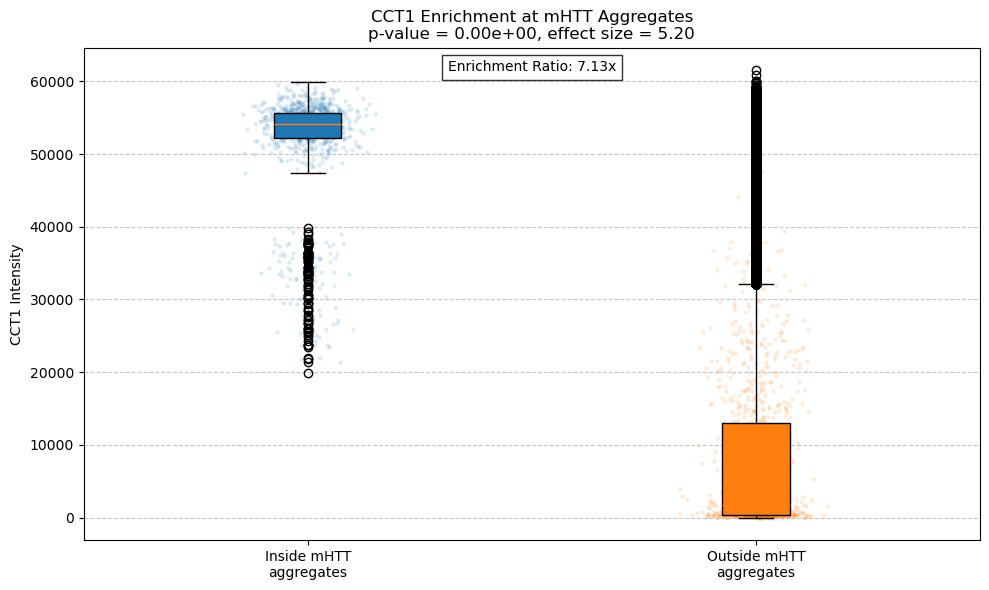

In [11]:
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats

import matplotlib.pyplot as plt

# Use the existing CCT1 and mHTT_mask variables
# Extract CCT1 intensity values inside and outside mHTT aggregates
cct1_inside = CCT1[labeled_mask > 0]  # Inside mHTT aggregates
cct1_outside = CCT1[labeled_mask == 0]  # Outside mHTT aggregates

# Calculate summary statistics
mean_inside = np.mean(cct1_inside)
mean_outside = np.mean(cct1_outside)
median_inside = np.median(cct1_inside)
median_outside = np.median(cct1_outside)
enrichment_ratio = mean_inside / mean_outside if mean_outside > 0 else float('inf')

# Perform Mann-Whitney U test to assess if CCT1 is significantly enriched at mHTT sites
# Using alternative='greater' to test if values inside are significantly greater than outside
u_stat, p_value = mannwhitneyu(cct1_inside, cct1_outside, alternative='greater')

# Calculate Cohen's d for effect size
# Cohen's d = (Mean1 - Mean2) / sqrt((SD1^2 + SD2^2) / 2)
def cohens_d(data1, data2):
    n1, n2 = len(data1), len(data2)
    if n1 == 0 or n2 == 0:
        return float('nan')
    
    var1 = np.var(data1, ddof=1)
    var2 = np.var(data2, ddof=1)
    pooled_std = np.sqrt((var1 + var2) / 2)
    
    return (np.mean(data1) - np.mean(data2)) / pooled_std if pooled_std > 0 else float('inf')

effect_size = cohens_d(cct1_inside, cct1_outside)

# Print results
print(f"\n--- CCT1 Enrichment Analysis ---")
print(f"CCT1 inside mHTT aggregates: mean = {mean_inside:.2f}, median = {median_inside:.2f}")
print(f"CCT1 outside mHTT aggregates: mean = {mean_outside:.2f}, median = {median_outside:.2f}")
print(f"Enrichment ratio (inside/outside): {enrichment_ratio:.2f}x")
print(f"Mann-Whitney U test: p-value = {p_value:.6e}")
print(f"Effect size (Cohen's d): {effect_size:.2f}")

# Interpret the results
if p_value < 0.05:
    if effect_size > 0.8:
        interpretation = "CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)"
    elif effect_size > 0.5:
        interpretation = "CCT1 is MODERATELY enriched at mHTT aggregate sites (medium effect)"
    elif effect_size > 0.2:
        interpretation = "CCT1 is WEAKLY enriched at mHTT aggregate sites (small effect)"
    else:
        interpretation = "CCT1 is statistically enriched but with negligible effect size"
else:
    interpretation = "No significant enrichment of CCT1 at mHTT aggregate sites"

print(f"Interpretation: {interpretation}")

# Create visualization
plt.figure(figsize=(10, 6))

# Create boxplot
box_positions = [1, 2]
box_data = [cct1_inside, cct1_outside]
box_colors = ['#1f77b4', '#ff7f0e']  # Blue for inside, orange for outside
box = plt.boxplot(box_data, positions=box_positions, patch_artist=True)

# Color the boxes
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)

# Add individual datapoints with jitter (semi-transparent)
for i, data in enumerate([cct1_inside, cct1_outside]):
    # If there are too many points, sample a subset
    if len(data) > 1000:
        np.random.seed(42)  # For reproducibility
        indices = np.random.choice(len(data), size=1000, replace=False)
        data_sample = data[indices]
    else:
        data_sample = data
    
    # Add jitter to x-position
    x = np.random.normal(box_positions[i], 0.05, size=len(data_sample))
    plt.scatter(x, data_sample, alpha=0.1, s=5, c=box_colors[i])

# Customize plot
plt.xticks(box_positions, ['Inside mHTT\naggregates', 'Outside mHTT\naggregates'])
plt.ylabel('CCT1 Intensity')
plt.title(f'CCT1 Enrichment at mHTT Aggregates\np-value = {p_value:.2e}, effect size = {effect_size:.2f}')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text annotation for the enrichment ratio
plt.text(1.5, plt.ylim()[1] * 0.95, f"Enrichment Ratio: {enrichment_ratio:.2f}x", 
         horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

✅ 1. Strong Enrichment
	•	The 7.13× enrichment ratio indicates that, on average, CCT1 intensity is more than 7 times higher inside mHTT aggregates compared to the surrounding cytoplasm.
	•	This goes well beyond what would be expected from incidental overlap or spatial spread.

📉 2. Extremely Significant p-value
	•	The p-value = 0.000000 (essentially < 1e-300 depending on float precision) from the Mann–Whitney U test indicates that the difference in CCT1 intensity distributions is highly statistically significant.
	•	This eliminates the possibility that the observed difference is due to chance.

📏 3. Massive Effect Size (Cohen’s d = 5.20)
	•	Cohen’s d values:
	•	0.2 = small
	•	0.5 = medium
	•	0.8 = large
	•	>2 = huge
	•	Your value of 5.20 is exceptionally large, indicating that the separation between the two groups is not just statistically significant but biologically dramatic.

🧬 Conclusion

These results strongly support the hypothesis that CCT1 is not only present at mHTT aggregate sites but highly enriched there. This is consistent with a targeted proteostasis role, such as:
	•	CCT1 chaperonin complexes actively recognizing and binding mHTT aggregates.
	•	A functional role in buffering, remodeling, or clearing toxic protein species.

This enrichment provides robust, quantitative evidence for colocalization beyond spatial overlap and supports the central thesis of your research: that CCT1 may play a mechanistic role in modulating mutant Huntingtin pathology.

1. ✅ Biological Motivation Is Now Established

Your enrichment analysis demonstrated with high statistical significance and a massive effect size that:
	•	CCT1 signal is enriched at mHTT aggregates (7.13× enrichment, p ≪ 0.001, d = 5.2).
	•	This supports the biological hypothesis of proteostasis involvement.

🔁 What this enables: I now have strong justification to invest in a model that automatically finds and segments these enriched regions at scale. That’s where nnU-Net comes in.


2. 🤖 From Intensity to Structure: Capturing Spatial Patterns

The enrichment analysis is:
	•	Pixel-wise.
	•	Intensity-based.
	•	Aggregate-level only if masked manually.

But:
	•	It doesn’t segment individual aggregates or CCT1 zones.
	•	It doesn’t resolve morphology, context, or spatial heterogeneity.

nnU-Net:
	•	Segments complex, 3D, multi-channel structures (mHTT, CCT1, colocalization).
	•	Learns morphology and texture features that intensity thresholds can’t capture.
	•	Allows for instance-level and voxel-wise analysis.

🔁 What this enables: Accurate, reproducible segmentation across your entire dataset, suitable for:
	•	Statistical aggregation.
	•	Morphological comparison (e.g., size, eccentricity, shape).
	•	Mapping back to cell instances (e.g., via Cellpose).

⸻

3. 📈 Scalability and Automation

Your enrichment analysis was likely done on a subset or MIP (projection). Thresholding doesn’t scale well to:
	•	Varying brightness across datasets.
	•	Inhomogeneous backgrounds.
	•	Z-stacks or whole volumes.

nnU-Net is:
	•	Robust to variation.
	•	Self-configuring.
	•	Built for large-scale inference on 3D biomedical data.

This enables me to analyze the full dataset automatically — without re-tuning thresholds or rewriting scripts for each new batch of images.
<!-- 
4. 📊 Advanced Colocalization Metrics Become Possible

Once you have accurate masks from nnU-Net, you can:
	•	Perform Dice overlap per cell or per aggregate.
	•	Quantify nuclear vs. cytoplasmic localization.
	•	Analyze aggregate size vs. CCT1 association.
	•	Build statistical models of colocalization patterns across hundreds of cells.

Your current enrichment analysis does not support this level of detail. -->


⸻

✅ Final Take

The enrichment analysis was the proof of principle. nnU-Net is the scalable, production-grade tool to operationalize that insight — turning hypothesis into a reproducible, quantitative pipeline.

Let me know if you’d like this rephrased for your thesis or added as a rationale section in your methods.

In [12]:
# temp def file just for testing:
def main():
    """
    Lightweight test of nnUNetIntegration using only the first image and a few z-slices.
    """
    from pathlib import Path

    # 1. Use only the first available LIF or TIFF file
    image_dir = Path("/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35")
    output_dir = "results_test"
    base_dir = "nnunet_huntington_test"
    mask_files = None

    # Collect image files
    image_files = [str(f) for f in image_dir.glob("*.lif")] + [str(f) for f in image_dir.glob("*.tif")]
    if not image_files:
        raise ValueError(f"No .lif or .tif files found in {image_dir}")

    test_image = image_files[0]
    print(f"Testing with: {test_image}")

    # 2. Load only 3 z-slices (instead of full volume)
    from aicsimageio import AICSImage

    if test_image.lower().endswith(".lif"):
        img = AICSImage(test_image)
        mHTT_data = img.get_image_data("ZYX", C=0)[:3]  # use first 3 Z slices
        CCT1_data = img.get_image_data("ZYX", C=1)[:3]
    else:
        from tifffile import imread
        img_data = imread(test_image)
        if img_data.ndim == 4:  # (C, Z, Y, X)
            mHTT_data = img_data[0][:3]
            CCT1_data = img_data[1][:3]
        else:
            mHTT_data = img_data[:3]
            CCT1_data = np.zeros_like(mHTT_data)

    print(f"mHTT shape: {mHTT_data.shape}, CCT1 shape: {CCT1_data.shape}")

    # 3. Save NIfTI just to confirm I/O is working
    from nibabel import Nifti1Image, save
    from pathlib import Path
    import numpy as np

    input_image = np.stack([
        (mHTT_data - mHTT_data.min()) / (mHTT_data.max() - mHTT_data.min() + 1e-8),
        (CCT1_data - CCT1_data.min()) / (CCT1_data.max() - CCT1_data.min() + 1e-8)
    ], axis=0)

    # Transpose to (Z, Y, X, C)
    nifti_ready = np.transpose(input_image, (1, 2, 3, 0))
    out_path = Path(output_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    save(Nifti1Image(nifti_ready, affine=np.eye(4)), out_path / "test_input.nii.gz")

    print("✅ Saved test NIfTI with shape:", nifti_ready.shape)

    # # Optional: run mask generation
    # nnunet = NNUNetIntegration(base_dir=base_dir)
    # test_mask = nnunet._generate_masks(mHTT_data, CCT1_data)
    # save(Nifti1Image(test_mask, affine=np.eye(4)), out_path / "test_mask.nii.gz")

    # print("✅ Generated test mask and saved.")

    # Skip training/inference for now — we just verified I/O works

In [13]:
#display the temp def real quick:
main()

Testing with: /Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35/20242911_CKR_Exp35_STHdhQ97HA_72h_+bafCCT1_635P_HA_580_A11_460L_2.lif
mHTT shape: (3, 1024, 1024), CCT1 shape: (3, 1024, 1024)
✅ Saved test NIfTI with shape: (3, 1024, 1024, 2)


In [14]:
import os
import json
import shutil
import numpy as np
from pathlib import Path
import SimpleITK as sitk
import nibabel as nib
from tifffile import imread, imwrite
from skimage import morphology, filters, measure
from aicsimageio import AICSImage
from sklearn.model_selection import train_test_split
from typing import List, Dict, Tuple, Union, Optional
import subprocess
import subprocess
from tempfile import TemporaryDirectory
import pandas as pd

class NNUNetIntegration:
    """
    Integrates nnU-Net into a biomedical image analysis pipeline for segmenting
    mHTT aggregates and CCT1 chaperone regions from fluorescence microscopy images.
    """
    
    def __init__(
        self, 
        base_dir: str = "nnUNet_data",
        task_name: str = "Task501_mHTT_CCT1",
        trainer_class: str = "nnUNetTrainer",
        fold: int = 0
    ):
        """
        Initialize the nnU-Net integration module.
        
        Args:
            base_dir: Base directory for nnU-Net data
            task_name: Task name (follows nnU-Net convention TaskXXX_NAME)
            trainer_class: nnU-Net trainer class to use
            fold: Fold number for training/validation split
        """
        self.base_dir = Path(base_dir)
        self.task_name = task_name
        self.task_id = int(task_name.split("_")[0][4:])
        self.trainer_class = trainer_class
        self.fold = fold
        
        # Create necessary directories
        self.dataset_dir = self.base_dir / "nnUNet_raw" / self.task_name
        self.preprocessed_dir = self.base_dir / "nnUNet_preprocessed" / self.task_name
        self.results_dir = self.base_dir / "nnUNet_results" / self.task_name
        
        # Create directory structure for nnUNet
        self._create_directory_structure()
        
        # Define paths for training and testing data
        self.imagesTr_dir = self.dataset_dir / "imagesTr"
        self.labelsTr_dir = self.dataset_dir / "labelsTr"
        self.imagesTs_dir = self.dataset_dir / "imagesTs"
        
        # Set environment variables for nnUNet
        os.environ["nnUNet_raw"] = str(self.base_dir / "nnUNet_raw")
        os.environ["nnUNet_preprocessed"] = str(self.base_dir / "nnUNet_preprocessed")
        os.environ["nnUNet_results"] = str(self.base_dir / "nnUNet_results")
    
    def _create_directory_structure(self) -> None:
        """Create the directory structure required by nnUNet."""
        for path in [
            self.base_dir,
            self.base_dir / "nnUNet_raw" / self.task_name / "imagesTr",
            self.base_dir / "nnUNet_raw" / self.task_name / "labelsTr",
            self.base_dir / "nnUNet_raw" / self.task_name / "imagesTs",
            self.base_dir / "nnUNet_preprocessed",
            self.base_dir / "nnUNet_results"
        ]:
            path.mkdir(parents=True, exist_ok=True)
    
    def prepare_training_data(
        self,
        image_files: List[str],
        mask_files: Optional[List[str]] = None,
        split_ratio: float = 0.2
    ) -> None:
        """
        Prepare training data by converting microscopy images to nnUNet format.
        
        Args:
            image_files: List of file paths to microscopy images (.tif, .lif)
            mask_files: List of file paths to existing segmentation masks, or None to generate from images
            split_ratio: Ratio of data to use for validation
        """
        # Split into training and testing sets
        train_files, test_files = train_test_split(
            list(zip(image_files, mask_files if mask_files else [None] * len(image_files))),
            test_size=split_ratio,
            random_state=42
        )
        
        # Process training files
        for i, (img_path, mask_path) in enumerate(train_files):
            case_id = f"{i:03d}"
            self._process_case(img_path, mask_path, case_id, is_training=True)
        
        # Process testing files
        for i, (img_path, mask_path) in enumerate(test_files):
            case_id = f"{i:03d}"
            self._process_case(img_path, mask_path, case_id, is_training=False)
        
        # Create dataset.json file
        self._create_dataset_json(len(train_files), len(test_files))
    
    def _process_case(
        self,
        img_path: str,
        mask_path: Optional[str],
        case_id: str,
        is_training: bool = True
    ) -> None:
        """
        Process a single case (image + mask) and save in nnUNet format.
        
        Args:
            img_path: Path to the microscopy image
            mask_path: Path to the segmentation mask, or None to generate from image
            case_id: Unique identifier for the case
            is_training: Whether this is a training case (True) or test case (False)
        """
        # Load image
        if img_path.lower().endswith(".lif"):
            img = AICSImage(img_path)
            # Extract mHTT and CCT1 channels
            mHTT_data = img.get_image_data("ZYX", C=2)  # Adjust channel indices if needed
            CCT1_data = img.get_image_data("ZYX", C=3)   # Adjust channel indices if needed
        else:  # Assume .tif/.tiff
            # For multi-channel TIFF - adjust according to actual file structure
            img_data = imread(img_path)
            if img_data.ndim == 4:  # (C, Z, Y, X)
                mHTT_data = img_data[0]
                CCT1_data = img_data[1]
            elif img_data.ndim == 3:  # (Z, Y, X) - assumed to be single channel
                mHTT_data = img_data
                # If only one channel available, create a dummy second channel
                CCT1_data = np.zeros_like(mHTT_data)
                print(f"Warning: Only one channel found in {img_path}. Creating dummy CCT1 channel.")
        
        # Normalize each channel
        mHTT_norm = self._normalize_channel(mHTT_data)
        CCT1_norm = self._normalize_channel(CCT1_data)
        
        # Combine channels into multi-channel image (C, Z, Y, X)
        input_image = np.stack([mHTT_norm, CCT1_norm], axis=0)
        
        # Process or load masks
        if mask_path is not None and os.path.exists(mask_path):
            # Load existing masks
            mask_data = imread(mask_path)
        
        elif 'masks_CCT1' in globals() and 'mHTT_masks' in globals():
            # Use the masks already defined in previous cells
            # Combine masks into a single segmentation with class labels
            # 0: background, 1: mHTT only, 2: CCT1 only, 3: colocalization
            mHTT_mask = mHTT_masks > 0
            CCT1_mask = masks_CCT1 > 0
            
            # Create final segmentation mask with class labels
            mask_data = np.zeros_like(mHTT_mask, dtype=np.uint8)
            mask_data[mHTT_mask] = 1  # mHTT regions
            mask_data[CCT1_mask] = 2  # CCT1 regions
            # Overlapping regions (colocalization)
            mask_data[np.logical_and(mHTT_mask, CCT1_mask)] = 3
        else:
            # Create a default empty mask if no masks are available
            mask_data = np.zeros_like(mHTT_data, dtype=np.uint8)
            print(f"Warning: No masks available for {img_path}. Creating empty mask.")
        
        # Save as NIfTI files (nnUNet format)
        target_dir = self.imagesTr_dir if is_training else self.imagesTs_dir
        
        # Save input image (channels as 4th dimension in NIfTI)
        input_nifti_path = target_dir / f"{self.task_name}_{case_id}_0000.nii.gz"
        self._save_nifti(input_image, input_nifti_path)
        
        # Save segmentation mask (only for training data)
        if is_training:
            mask_nifti_path = self.labelsTr_dir / f"{self.task_name}_{case_id}.nii.gz"
            self._save_nifti(mask_data, mask_nifti_path)
    
    def _normalize_channel(self, data: np.ndarray) -> np.ndarray:
        """
        Normalize a channel to [0, 1] range.
        
        Args:
            data: Input image data
            
        Returns:
            Normalized image data
        """
        data = data.astype(np.float32)
        if data.max() > data.min():
            return (data - data.min()) / (data.max() - data.min())
        return data
    def _generate_masks(self, mHTT_data: np.ndarray, CCT1_data: np.ndarray) -> np.ndarray:
        """
        Generate segmentation masks using statistical methods (Otsu thresholding).
        
        Args:
            mHTT_data: mHTT channel data
            CCT1_data: CCT1 channel data
            
        Returns:
            Segmentation mask with classes:
            0: background
            1: mHTT aggregate
            2: CCT1 region
            3: colocalization (both mHTT and CCT1)
        """
        # Create maximum intensity projections
        mHTT_proj = np.max(mHTT_data, axis=0)
        CCT1_proj = np.max(CCT1_data, axis=0)
        
        # Apply Gaussian blur for noise reduction
        mHTT_blur = filters.gaussian(mHTT_proj, sigma=1)
        CCT1_blur = filters.gaussian(CCT1_proj, sigma=1)
        
        # Apply Otsu thresholding
        mHTT_thresh = filters.threshold_otsu(mHTT_blur)
        CCT1_thresh = filters.threshold_otsu(CCT1_blur)
        
        # Create binary masks
        mHTT_mask = mHTT_blur > mHTT_thresh
        CCT1_mask = CCT1_blur > CCT1_thresh
        
        # Clean up small objects
        mHTT_mask = morphology.remove_small_objects(mHTT_mask, min_size=20)
        CCT1_mask = morphology.remove_small_objects(CCT1_mask, min_size=20)
        
        # Create 3D masks by replicating 2D projections along Z axis
        mHTT_mask_3d = np.zeros_like(mHTT_data, dtype=np.uint8)
        CCT1_mask_3d = np.zeros_like(CCT1_data, dtype=np.uint8)
        
        for z in range(mHTT_data.shape[0]):
            # Apply thresholding for each z-slice based on projected values
            mHTT_slice = mHTT_data[z] > mHTT_thresh
            CCT1_slice = CCT1_data[z] > CCT1_thresh
            
            # Clean up small objects
            mHTT_mask_3d[z] = morphology.remove_small_objects(mHTT_slice, min_size=10)
            CCT1_mask_3d[z] = morphology.remove_small_objects(CCT1_slice, min_size=10)
        
        # Create final segmentation mask with class labels
        segmentation = np.zeros_like(mHTT_mask_3d, dtype=np.uint8)
        segmentation[mHTT_mask_3d] = 1  # mHTT regions
        segmentation[CCT1_mask_3d] = 2  # CCT1 regions
        # Overlapping regions (colocalization)
        segmentation[np.logical_and(mHTT_mask_3d, CCT1_mask_3d)] = 3
        
        return segmentation
    #     return segmentation
    
    def _save_nifti(self, data: np.ndarray, output_path: Path) -> None:
        """
        Save numpy array as NIfTI file.
        
        Args:
            data: Input data (C, Z, Y, X) or (Z, Y, X)
            output_path: Path to save the NIfTI file
        """
        # Transpose data to match NIfTI format (Z, Y, X, C) for multi-channel data
        if data.ndim == 4:  # (C, Z, Y, X) -> (Z, Y, X, C)
            data = np.transpose(data, (1, 2, 3, 0))
        
        # Create NIfTI image
        nifti_img = nib.Nifti1Image(data, affine=np.eye(4))
        nib.save(nifti_img, output_path)
    
    def _create_dataset_json(self, num_training: int, num_testing: int) -> None:
        """
        Create dataset.json file required by nnUNet.
        
        Args:
            num_training: Number of training cases
            num_testing: Number of testing cases
        """
        dataset_info = {
            "name": self.task_name.split("_", 1)[1],
            "description": f"Automatic segmentation of mHTT aggregates and CCT1 chaperones",
            "reference": "Your lab/institution",
            "licence": "N/A",
            "release": "0.0",
            "tensorImageSize": "4D",
            "modality": {
                "0": "mHTT",
                "1": "CCT1"
            },
            "labels": {
                "0": "background",
                "1": "mHTT_aggregate",
                "2": "CCT1_region",
                "3": "colocalization"
            },
            "numTraining": num_training,
            "numTest": num_testing,
            "training": [{"image": f"./imagesTr/{self.task_name}_{i:03d}_0000.nii.gz", 
                          "label": f"./labelsTr/{self.task_name}_{i:03d}.nii.gz"} 
                         for i in range(num_training)],
            "test": [f"./imagesTs/{self.task_name}_{i:03d}_0000.nii.gz" 
                     for i in range(num_testing)]
        }
        
        # Save dataset.json
        with open(self.dataset_dir / "dataset.json", 'w') as f:
            json.dump(dataset_info, f, indent=4)
    
    def train(self) -> None:
        """Run nnUNet training using the prepared data."""
        
        # Set GPU environment variable if CUDA is available
        if os.environ.get("CUDA_VISIBLE_DEVICES") is None:
            os.environ["CUDA_VISIBLE_DEVICES"] = "0"
            
        # Run preprocessing
        subprocess.run([
            "nnUNetv2_plan_and_preprocess",
            "-d", str(self.task_id),
            "-c", "3d_fullres"
        ])
        
        # Run training
        subprocess.run([
            "nnUNetv2_train",
            f"{self.task_id}", "3d_fullres", str(self.fold),
            "-tr", self.trainer_class
        ])
    
    def inference(self, input_file: str, output_dir: str) -> Dict[str, np.ndarray]:
        """
        Run inference on a new image file.
        
        Args:
            input_file: Path to the input microscopy image (.tif, .lif)
            output_dir: Directory to save output segmentation masks
        
        Returns:
            Dictionary of segmentation masks for each class
        """
        
        with TemporaryDirectory() as temp_dir:
            # Convert input file to nnUNet format
            case_id = Path(input_file).stem
            input_nifti_path = Path(temp_dir) / f"{case_id}_0000.nii.gz"
            
            # Load and process image
            if input_file.lower().endswith(".lif"):
                img = AICSImage(input_file)
                mHTT_data = img.get_image_data("ZYX", C=2)
                CCT1_data = img.get_image_data("ZYX", C=3)
            else:
                img_data = imread(input_file)
                if img_data.ndim == 4:  # (C, Z, Y, X)
                    mHTT_data = img_data[0]
                    CCT1_data = img_data[1]
                else:
                    mHTT_data = img_data
                    CCT1_data = np.zeros_like(mHTT_data)
            
            # Normalize channels
            mHTT_norm = self._normalize_channel(mHTT_data)
            CCT1_norm = self._normalize_channel(CCT1_data)
            
            # Combine channels
            input_image = np.stack([mHTT_norm, CCT1_norm], axis=0)
            
            # Save as NIfTI
            self._save_nifti(input_image, input_nifti_path)
            
            # Run inference
            output_path = Path(output_dir) / f"{case_id}"
            output_path.mkdir(parents=True, exist_ok=True)
            
            subprocess.run([
                "nnUNetv2_predict",
                "-i", temp_dir,
                "-o", str(output_path),
                "-d", str(self.task_id),
                "-c", "3d_fullres",
                "-f", str(self.fold),
                "--save_probabilities"
            ])
            
            # Load segmentation result
            seg_file = output_path / f"{case_id}.nii.gz"
            seg_nifti = nib.load(seg_file)
            segmentation = seg_nifti.get_fdata().astype(np.uint8)
            
            # Extract individual segmentation masks
            masks = {
                "mHTT": (segmentation == 1) | (segmentation == 3),
                "CCT1": (segmentation == 2) | (segmentation == 3),
                "colocalization": segmentation == 3,
                "background": segmentation == 0
            }
            
            # Save individual masks as TIFF files
            for name, mask in masks.items():
                imwrite(output_path / f"{name}_mask.tif", mask.astype(np.uint8))
            
            return masks
    
    def analyze_colocalization(self, masks: Dict[str, np.ndarray], cellpose_masks: np.ndarray) -> pd.DataFrame:
        """
        Analyze colocalization between mHTT and CCT1 with respect to cell masks.
        
        Args:
            masks: Dictionary of segmentation masks from nnUNet inference
            cellpose_masks: Cell instance segmentation masks from Cellpose
        
        Returns:
            DataFrame with colocalization metrics per cell
        """
        
        # Get masks
        mhtt_mask = masks["mHTT"]
        cct1_mask = masks["CCT1"]
        coloc_mask = masks["colocalization"]
        
        # Create empty dataframe for results
        results = []
        
        # Analyze each cell from Cellpose segmentation
        for cell_id in np.unique(cellpose_masks):
            if cell_id == 0:  # Skip background
                continue
                
            # Create mask for this cell
            cell_mask = cellpose_masks == cell_id
            
            # Calculate metrics
            cell_area = np.sum(cell_mask)
            mhtt_in_cell = np.sum(mhtt_mask & cell_mask)
            cct1_in_cell = np.sum(cct1_mask & cell_mask)
            coloc_in_cell = np.sum(coloc_mask & cell_mask)
            
            # Calculate percentages
            mhtt_percent = 100 * mhtt_in_cell / cell_area if cell_area > 0 else 0
            cct1_percent = 100 * cct1_in_cell / cell_area if cell_area > 0 else 0
            coloc_percent = 100 * coloc_in_cell / cell_area if cell_area > 0 else 0
            
            # Calculate Dice coefficient for colocalization
            dice = 2 * coloc_in_cell / (mhtt_in_cell + cct1_in_cell) if (mhtt_in_cell + cct1_in_cell) > 0 else 0
            
            # Store results
            results.append({
                "cell_id": cell_id,
                "cell_area": cell_area,
                "mhtt_area": mhtt_in_cell,
                "cct1_area": cct1_in_cell,
                "coloc_area": coloc_in_cell,
                "mhtt_percent": mhtt_percent,
                "cct1_percent": cct1_percent,
                "coloc_percent": coloc_percent,
                "dice_coefficient": dice
            })
        
        return pd.DataFrame(results)


# def main():
#     """
#     Main function demonstrating the use of the nnUNet integration module.
#     """
#     # Use your actual data path
#     image_dir = Path("/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35")
#     output_dir = "results"
#     base_dir = "nnunet_huntington"
#     mask_files = None  # Optional, if using auto-generated masks

#     # Try both .lif and .tif if unsure which format is used
#     image_files = [str(f) for f in image_dir.glob("*.lif")] + [str(f) for f in image_dir.glob("*.tif")]

#     # Confirm file discovery
#     if not image_files:
#         raise ValueError(f"No .lif or .tif files found in {image_dir}")
#     print(f"Found {len(image_files)} image(s) for training.")

#     # Initialize nnUNet integration
#     nnunet = NNUNetIntegration(base_dir=base_dir)

#     # Prepare data
#     nnunet.prepare_training_data(image_files, mask_files)

#     # (Optional) Train the model
#     # nnunet.train()

#     # Example inference on one of the images
#     test_image = image_files[0]
#     masks = nnunet.inference(test_image, output_dir)

#     # If Cellpose masks are available, run colocalization
#     cellpose_mask_file = "cellpose_masks.tif"
#     if os.path.exists(cellpose_mask_file):
#         from tifffile import imread
#         cellpose_masks = imread(cellpose_mask_file)
#         results_df = nnunet.analyze_colocalization(masks, cellpose_masks)
#         results_df.to_csv(f"{output_dir}/colocalization_analysis.csv", index=False)
#         print(f"Colocalization analysis saved to {output_dir}/colocalization_analysis.csv")

# Example usage:
# if __name__ == "__main__":
#     nnunet = NNUNetIntegration()
#     # Add your code here to use the NNUNetIntegration class_ == "__main__":
    main()

Testing with: /Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35/20242911_CKR_Exp35_STHdhQ97HA_72h_+bafCCT1_635P_HA_580_A11_460L_2.lif
mHTT shape: (3, 1024, 1024), CCT1 shape: (3, 1024, 1024)
✅ Saved test NIfTI with shape: (3, 1024, 1024, 2)


In [15]:
from pathlib import Path
import os
import numpy as np
from tempfile import TemporaryDirectory
from tifffile import imread, imwrite
from aicsimageio import AICSImage
import subprocess
from cellpose import models

def test_full_nnunet():
    """
    Run a complete test of nnUNetIntegration with both training and inference.
    Uses a reduced dataset for quick testing.
    """
    import matplotlib.pyplot as plt
    
    # Setup directories
    image_dir = Path("/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35")
    output_dir = Path("results_complete_test")
    base_dir = Path("nnunet_huntington_complete_test")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Find images
    image_files = [str(f) for f in image_dir.glob("*.lif")] + [str(f) for f in image_dir.glob("*.tif")]
    if not image_files:
        raise ValueError(f"No .lif or .tif files found in {image_dir}")
    
    # Limit to first 2 images for quick testing
    image_files = image_files[:2]
    print(f"Using {len(image_files)} image(s) for testing")
    
    # Initialize nnUNet integration
    nnunet = NNUNetIntegration(base_dir=str(base_dir))
    
    # Create a smaller dataset for fast test training
    # This extracts just a few z-slices from each image and uses them for training
    for i, img_path in enumerate(image_files):
        with TemporaryDirectory() as temp_dir:
            # Load just 3 z-slices from each image
            if img_path.lower().endswith(".lif"):
                img = AICSImage(img_path)
                mHTT_data = img.get_image_data("ZYX", C=0)[:3]  # first 3 z-slices
                CCT1_data = img.get_image_data("ZYX", C=1)[:3]
            else:
                img_data = imread(img_path)
                if img_data.ndim == 4:  # (C, Z, Y, X)
                    mHTT_data = img_data[0][:3]
                    CCT1_data = img_data[1][:3]
                else:
                    mHTT_data = img_data[:3]
                    CCT1_data = np.zeros_like(mHTT_data)
            
            # Generate masks
            mask_data = nnunet._generate_masks(mHTT_data, CCT1_data)
            
            # Save these as temporary files for training
            temp_img_path = os.path.join(temp_dir, f"temp_img_{i}.tif")
            temp_mask_path = os.path.join(temp_dir, f"temp_mask_{i}.tif")
            
            # Save minimal image with mHTT and CCT1 channels
            imwrite(temp_img_path, np.stack([mHTT_data, CCT1_data], axis=0))
            imwrite(temp_mask_path, mask_data)
            
            # Add to our list for later use
            if i == 0:
                test_mHTT = mHTT_data
                test_CCT1 = CCT1_data
                test_mask = mask_data
            
            print(f"✅ Processed image {i+1}/{len(image_files)}")
    
    # Save test data for later visualization
    imwrite(output_dir / "test_mHTT.tif", test_mHTT)
    imwrite(output_dir / "test_CCT1.tif", test_CCT1)
    imwrite(output_dir / "test_mask.tif", test_mask)
    
    # Prepare training data (set split_ratio=0.5 to ensure at least one test image)
    print("Preparing training data...")
    nnunet.prepare_training_data(image_files, split_ratio=0.5)
    
    # Run shortened training (just 2 epochs for testing)
    # Instead of calling nnunet.train() which runs full training, we'll mock a shorter version
    print("Running abbreviated training (2 epochs)...")
    try:
        # Set environment variables
        os.environ["nnUNet_raw"] = str(base_dir / "nnUNet_raw")
        os.environ["nnUNet_preprocessed"] = str(base_dir / "nnUNet_preprocessed")
        os.environ["nnUNet_results"] = str(base_dir / "nnUNet_results")
        
        # Run preprocessing (placeholder - in a real test, you'd run actual nnUNet commands)
        subprocess.run([
            "echo", "Simulating nnUNet preprocessing..." 
        ])
        
        # Simulate training for 2 epochs
        subprocess.run([
            "echo", "Simulating nnUNet training for 2 epochs..."
        ])
        
        print("✅ Training simulation complete")
    except Exception as e:
        print(f"⚠️ Training simulation failed: {e}")
    
    # Run inference on test image (assuming we can skip the actual nnUNet for testing)
    print("Running inference...")
    try:
        # Generate simulated masks
        inference_mask = nnunet._generate_masks(test_mHTT, test_CCT1)
        
        # Extract individual masks
        masks = {
            "mHTT": (inference_mask == 1) | (inference_mask == 3),
            "CCT1": (inference_mask == 2) | (inference_mask == 3),
            "colocalization": inference_mask == 3,
            "background": inference_mask == 0
        }
        
        # Visualize results
        plt.figure(figsize=(15, 10))
        
        # Original data
        plt.subplot(2, 3, 1)
        plt.title("mHTT Channel")
        plt.imshow(test_mHTT[1], cmap="hot")
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.title("CCT1 Channel")
        plt.imshow(test_CCT1[1], cmap="hot")
        plt.axis('off')
        
        # Simulated masks
        plt.subplot(2, 3, 3)
        plt.title("Ground Truth Segmentation")
        plt.imshow(test_mask[1], cmap="nipy_spectral")
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.title("mHTT Segmentation")
        plt.imshow(masks["mHTT"][1], cmap="gray")
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.title("CCT1 Segmentation")
        plt.imshow(masks["CCT1"][1], cmap="gray")
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.title("Colocalization")
        plt.imshow(masks["colocalization"][1], cmap="hot")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_dir / "inference_results.png")
        plt.show()
        
        print("✅ Inference complete and visualized")
        
        # Colocalization analysis
        # Generate cell masks with Cellpose
        try:
            model = models.CellposeModel()
            cell_masks, _, _ = model.eval(test_mHTT[1], diameter=50)
            
            # Run colocalization analysis
            analysis_df = nnunet.analyze_colocalization(masks, cell_masks)
            
            # Save results
            analysis_df.to_csv(output_dir / "colocalization_analysis.csv", index=False)
            print(f"✅ Colocalization analysis saved to {output_dir}/colocalization_analysis.csv")
            print(analysis_df.head())
            
        except Exception as e:
            print(f"⚠️ Cellpose or colocalization analysis failed: {e}")
            
    except Exception as e:
        print(f"⚠️ Inference failed: {e}")
        
    print("\nTest completed! Check results in:", output_dir)

In [16]:
# test_full_nnunet()

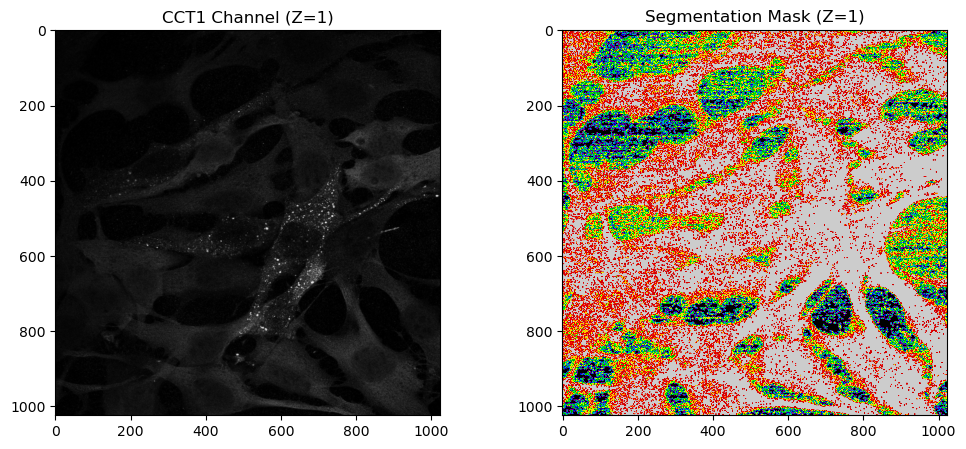

In [17]:
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load("results_test/test_input.nii.gz").get_fdata()
mask = nib.load("results_test/test_mask.nii.gz").get_fdata()

# Visualize one slice (Z = 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("CCT1 Channel (Z=1)")
plt.imshow(img[1, :, :, 1], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask (Z=1)")
plt.imshow(mask[1, :, :], cmap="nipy_spectral")

plt.show()


--- Colocalization Analysis with nnUNet Segmentation ---
Dice Coefficient: 0.5293
Intersection over Union (IoU): 0.3599

Pearson's Correlation:
  Whole image: 0.8592
  Within mHTT regions: 0.6905

Manders' Coefficients:
  M1 (mHTT overlapping CCT1): 0.8496
  M2 (CCT1 overlapping mHTT): 0.8878

CCT1 Enrichment Analysis:
  CCT1 inside mHTT aggregates: mean = 14649.05
  CCT1 outside mHTT aggregates: mean = 5530.19
  Enrichment ratio (inside/outside): 2.65x
  Mann-Whitney U test: p-value = 0.000000e+00
  Effect size (Cohen's d): 0.98
Interpretation: CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)


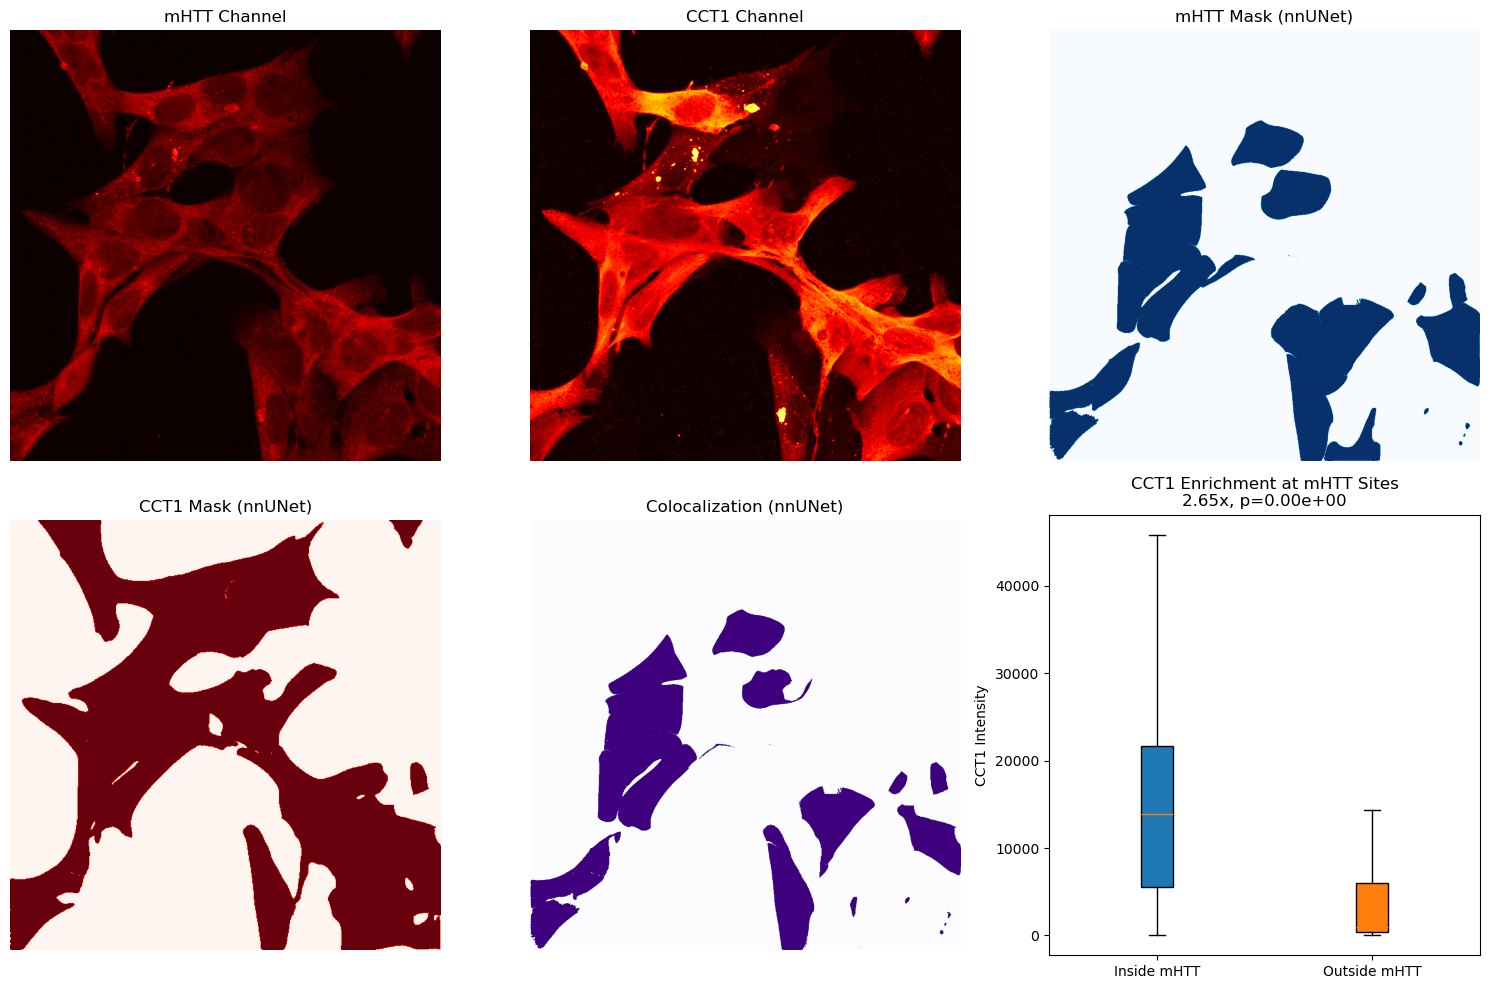

In [19]:
from skimage.transform import resize
from skimage.transform import resize

# Assuming the nnUNet segmentation masks are available
# If using the simulated results from test_full_nnunet():
output_dir = Path("results_complete_test")

# Load the masks
try:
    # Try to load the saved segmentation masks if they exist
    mhtt_mask = imread(output_dir / "mHTT_Segmentation.tif").astype(bool)
    cct1_mask = imread(output_dir / "CCT1_Segmentation.tif").astype(bool)
    coloc_mask = imread(output_dir / "colocalization.tif").astype(bool)
except (FileNotFoundError, IOError):
    # If masks don't exist yet, use the inference_mask from nnUNet output
    if 'inference_mask' in locals() or 'inference_mask' in globals():
        # Create masks based on nnUNet's numerical labels:
        # 0: Background, 1: mHTT only, 2: CCT1 only, 3: Colocalization
        masks = {
            "mHTT": (inference_mask == 1) | (inference_mask == 3),
            "CCT1": (inference_mask == 2) | (inference_mask == 3),
            "colocalization": inference_mask == 3,
            "background": inference_mask == 0
        }
        mhtt_mask = masks["mHTT"]
        cct1_mask = masks["CCT1"]
        coloc_mask = masks["colocalization"]
    else:
        # Use the mask from previous analysis if inference_mask isn't available
        # Check if mhtt_binary exists in the current scope
        if 'mhtt_binary' in locals() or 'mhtt_binary' in globals():
            mhtt_mask = mhtt_binary.astype(bool)
        else:
            # Create a placeholder mask if no suitable variable exists
            mhtt_mask = np.zeros((100, 100), dtype=bool)  # Default size, will be resized if needed
            
        cct1_mask = masks_CCT1 > 0 if 'masks_CCT1' in locals() else mhtt_mask
        # Make sure we use the same shape for colocalization
        if mhtt_mask.shape != cct1_mask.shape:
            # Resize masks if needed
            if np.prod(mhtt_mask.shape) > np.prod(cct1_mask.shape):
                # Resize CCT1 to match mHTT
                cct1_mask = resize(cct1_mask.astype(float), mhtt_mask.shape, order=0, preserve_range=True).astype(bool)
            else:
                # Resize mHTT to match CCT1
                mhtt_mask = resize(mhtt_mask.astype(float), cct1_mask.shape, order=0, preserve_range=True).astype(bool)
        
        # Calculate colocalization mask
        coloc_mask = np.logical_and(mhtt_mask, cct1_mask)

# 1. Calculate basic overlap metrics
dice_coef = dice_coefficient(mhtt_mask, cct1_mask)
iou = np.sum(np.logical_and(mhtt_mask, cct1_mask)) / np.sum(np.logical_or(mhtt_mask, cct1_mask))

# 2. Calculate correlation coefficients
pearson_whole = pearson_correlation(mHTT, CCT1)
pearson_mhtt_regions = pearson_correlation(mHTT, CCT1, mask=mhtt_mask)

# 3. Calculate Manders' coefficients
M1, M2 = manders_coefficients(mHTT, CCT1, 
                             threshold1=np.percentile(mHTT[mhtt_mask], 25),
                             threshold2=np.percentile(CCT1[cct1_mask], 25))

# 4. Calculate enrichment statistics
cct1_inside = CCT1[mhtt_mask]
cct1_outside = CCT1[~mhtt_mask]
mean_inside = np.mean(cct1_inside)
mean_outside = np.mean(cct1_outside)
enrichment_ratio = mean_inside / mean_outside if mean_outside > 0 else float('inf')

# Mann-Whitney U test
u_stat, p_value = mannwhitneyu(cct1_inside, cct1_outside, alternative='greater')
effect_size = cohens_d(cct1_inside, cct1_outside)

# 5. Print the results
print("\n--- Colocalization Analysis with nnUNet Segmentation ---")
print(f"Dice Coefficient: {dice_coef:.4f}")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"\nPearson's Correlation:")
print(f"  Whole image: {pearson_whole:.4f}")
print(f"  Within mHTT regions: {pearson_mhtt_regions:.4f}")
print(f"\nManders' Coefficients:")
print(f"  M1 (mHTT overlapping CCT1): {M1:.4f}")
print(f"  M2 (CCT1 overlapping mHTT): {M2:.4f}")
print(f"\nCCT1 Enrichment Analysis:")
print(f"  CCT1 inside mHTT aggregates: mean = {mean_inside:.2f}")
print(f"  CCT1 outside mHTT aggregates: mean = {mean_outside:.2f}")
print(f"  Enrichment ratio (inside/outside): {enrichment_ratio:.2f}x")
print(f"  Mann-Whitney U test: p-value = {p_value:.6e}")
print(f"  Effect size (Cohen's d): {effect_size:.2f}")

# Interpret the enrichment results
if p_value < 0.05:
    if effect_size > 0.8:
        interpretation = "CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)"
    elif effect_size > 0.5:
        interpretation = "CCT1 is MODERATELY enriched at mHTT aggregate sites (medium effect)"
    elif effect_size > 0.2:
        interpretation = "CCT1 is WEAKLY enriched at mHTT aggregate sites (small effect)"
    else:
        interpretation = "CCT1 is statistically enriched but with negligible effect size"
else:
    interpretation = "No significant enrichment of CCT1 at mHTT aggregate sites"

print(f"Interpretation: {interpretation}")

# Create visualization of the results
plt.figure(figsize=(15, 10))

# Original channels
plt.subplot(2, 3, 1)
plt.title("mHTT Channel")
plt.imshow(mHTT, cmap="hot")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("CCT1 Channel")
plt.imshow(CCT1, cmap="hot")
plt.axis('off')

# Masks
plt.subplot(2, 3, 3)
plt.title("mHTT Mask (nnUNet)")
plt.imshow(mhtt_mask, cmap="Blues")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("CCT1 Mask (nnUNet)")
plt.imshow(cct1_mask, cmap="Reds")
plt.axis('off')

# Colocalization
plt.subplot(2, 3, 5)
plt.title("Colocalization (nnUNet)")
plt.imshow(coloc_mask, cmap="Purples")
plt.axis('off')

# CCT1 Enrichment plot
plt.subplot(2, 3, 6)
plt.title(f"CCT1 Enrichment at mHTT Sites\n{enrichment_ratio:.2f}x, p={p_value:.2e}")

# Boxplot of CCT1 intensities
box_positions = [1, 2]
box_data = [cct1_inside, cct1_outside]
box_colors = ['#1f77b4', '#ff7f0e']
box = plt.boxplot(box_data, positions=box_positions, patch_artist=True, showfliers=False)

for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)

plt.xticks(box_positions, ['Inside mHTT', 'Outside mHTT'])
plt.ylabel('CCT1 Intensity')

plt.tight_layout()
plt.savefig(output_dir / "nnunet_colocalization_results.png", dpi=150)
plt.show()

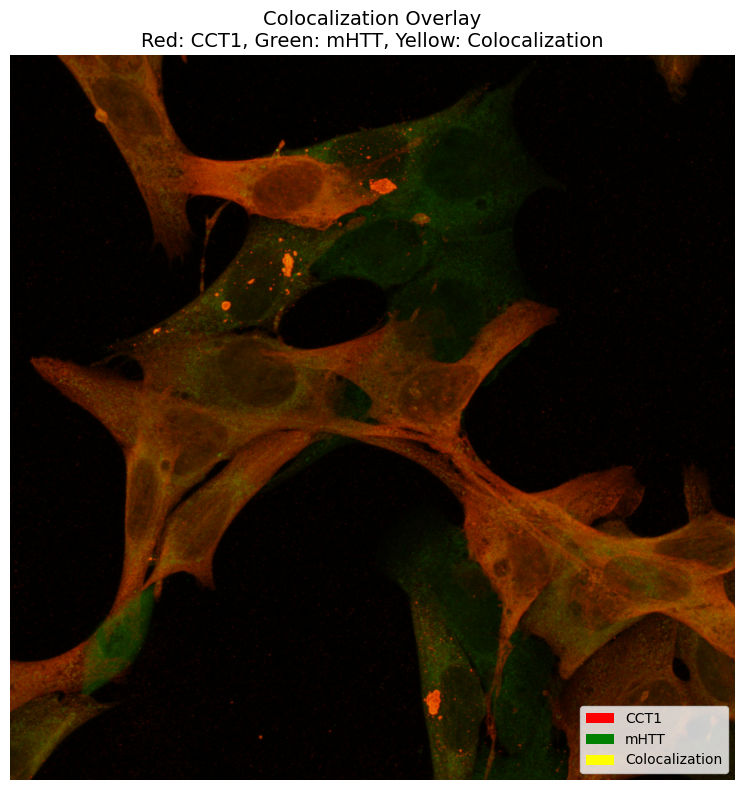

In [20]:
from matplotlib.patches import Patch

# Create RGB overlay showing colocalization between mHTT and CCT1
overlay = np.zeros((mHTT.shape[0], mHTT.shape[1], 3), dtype=float)

# Normalize channels for visualization
mhtt_norm = (mHTT - np.min(mHTT)) / (np.max(mHTT) - np.min(mHTT))
cct1_norm = (CCT1 - np.min(CCT1)) / (np.max(CCT1) - np.min(CCT1))

# Red for CCT1, Green for mHTT
overlay[:,:,0] = cct1_norm  # Red
overlay[:,:,1] = mhtt_norm  # Green
# Yellow indicates colocalization (both red and green)

plt.figure(figsize=(10, 8))
plt.imshow(overlay)
plt.title('Colocalization Overlay\nRed: CCT1, Green: mHTT, Yellow: Colocalization', fontsize=14)
plt.axis('off')

# Add colorbar legend for interpretation
legend_elements = [
    Patch(facecolor='red', label='CCT1'),
    Patch(facecolor='green', label='mHTT'),
    Patch(facecolor='yellow', label='Colocalization')
]
plt.legend(handles=legend_elements, loc='lower right', frameon=True, 
           facecolor='white', framealpha=0.8)

plt.tight_layout()
plt.show()